## Task 1-3

In [54]:
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torchvision.models as models

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


In [55]:
class Net(nn.Module):
        def __init__(self):
                super(Net, self).__init__()
                self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
                self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
                self.conv3 = nn.Conv2d(32,64, kernel_size=5)
                self.fc1 = nn.Linear(3*3*64, 256)
                self.fc2 = nn.Linear(256, 10)

        def feature(self,x):
                x = F.relu(self.conv1(x))
                x = F.relu(F.max_pool2d(self.conv2(x), 2))
                x = F.dropout(x, p=0.5, training=self.training)
                x = F.relu(F.max_pool2d(self.conv3(x),2))
                x = F.dropout(x, p=0.5, training=self.training)
                x = x.view(x.size(0), -1)
                return x
                
        def forward(self, x):
                x = self.feature(x)
                x = F.relu(self.fc1(x))
                x = F.dropout(x, training=self.training)
                x = self.fc2(x)
                return F.log_softmax(x, dim=1)

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [56]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):

    train_losses = []
    valid_losses = []
    best_model_loss = 5
    
    for epoch in range(num_epochs):

        # Training
        model.train()
        for i, (data, labels) in enumerate(train_loader):
      
            prediction = model(data)

            train_loss = criterion(prediction, labels)

            train_loss.backward()

            optimizer.step()

            optimizer.zero_grad()
        print(f'\rEpoch {epoch+1}, batch {i+1}/{len(train_loader)} - Loss: {train_loss}')

        train_losses.append(train_loss)
        writer.add_scalar("Loss/train ADAM", train_loss, epoch)

        # Validation
        model.eval()
        for batch_nr, (data, labels) in enumerate(val_loader):
            prediction = model.forward(data)
            loss_val = criterion(prediction, labels)
            valid_losses.append(loss_val)
        print(f"loss validation: {loss_val}")

        if valid_losses[-1] < best_model_loss:
            print(f"\t > Found a better model, {best_model_loss} -> {valid_losses[-1]}")
            best_model = copy.deepcopy(model)
            best_model_loss = valid_losses[-1]

        writer.add_scalar("Loss/validation ADAM", loss_val, epoch)

    print(f"\nBest model loss: {best_model_loss}")
    return best_model, train_losses, valid_losses

def get_accuracy(network, loader):
    
    with torch.no_grad():
        correct = 0
        total = 0
        y_pred = []
        y_true = []

        for x, (data, labels) in enumerate(loader):

            prediction = network.forward(data)

            for i in range(len(data)):

                y_true.append(labels[i].item())
                y_pred.append(torch.argmax(prediction[i]).item())
                if y_true[i] == y_pred[i]:
                    correct += 1        
    
            total += float(len(data))
    
        score = correct/total

        accuracy = score

        return accuracy
    

In [57]:

LEARNING_RATE = 1e-6
EPOCHS = 1
BATCH_SIZE = 1000

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,download=True, transform=transform)

validset, trainset = torch.utils.data.random_split(trainset, [10000, 50000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

# Train the model
trained_model, train_loss, valid_loss = train_model(model, criterion, optimizer, trainloader, validloader, EPOCHS)

# Test the model
test_acc = get_accuracy(trained_model, testloader)
print(f"Model Accuracy (MNIST): {test_acc*100}%")
writer.flush()


Epoch 1, batch 50/50 - Loss: 2.300710916519165
loss validation: 2.3005993366241455
	 > Found a better model, 5 -> 2.3005993366241455

Best model loss: 2.3005993366241455
Model Accuracy (MNIST): 13.3%


In [58]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

[Text(0.5, 1.0, 'MNIST data t-SNE projection')]

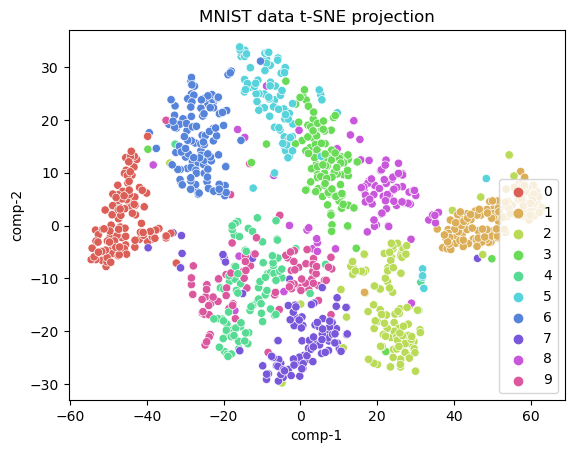

In [59]:
images, labels = next(iter(trainloader))
f = trained_model.feature(images)

tsne = TSNE(n_components=2,random_state=123)
z = tsne.fit_transform(f.detach().numpy())
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data t-SNE projection")

[Text(0.5, 1.0, 'MNIST data PCA projection')]

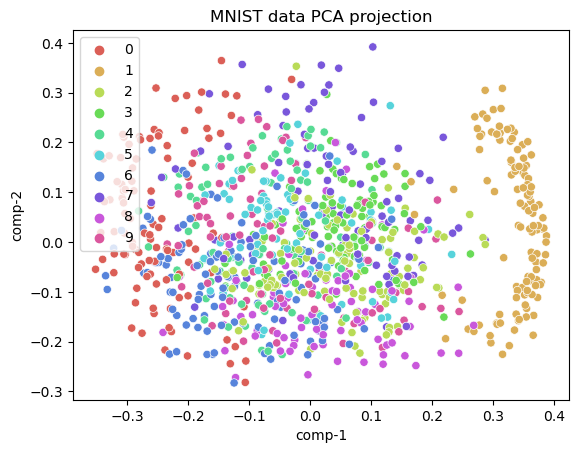

In [60]:
pca = PCA(n_components=2)
p = pca.fit_transform(f.detach().numpy())

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = p[:,0]
df["comp-2"] = p[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data PCA projection")

## Task 4-5


In [61]:

LEARNING_RATE = 1e-3
EPOCHS = 15
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-5)

# Train the model
trained_model, train_loss, valid_loss = train_model(model, criterion, optimizer, trainloader, validloader, EPOCHS)

# Test the model
test_acc = get_accuracy(trained_model, testloader)
print(f"Model Accuracy (MNIST): {test_acc*100}%")
writer.flush()

Epoch 1, batch 50/50 - Loss: 0.3133041560649872
loss validation: 0.19121763110160828
	 > Found a better model, 5 -> 0.19121763110160828
Epoch 2, batch 50/50 - Loss: 0.1355738341808319
loss validation: 0.08893633633852005
	 > Found a better model, 0.19121763110160828 -> 0.08893633633852005
Epoch 3, batch 50/50 - Loss: 0.11297766864299774
loss validation: 0.06913015991449356
	 > Found a better model, 0.08893633633852005 -> 0.06913015991449356
Epoch 4, batch 50/50 - Loss: 0.10696969926357269
loss validation: 0.07708258181810379
Epoch 5, batch 50/50 - Loss: 0.11800922453403473
loss validation: 0.046249233186244965
	 > Found a better model, 0.06913015991449356 -> 0.046249233186244965
Epoch 6, batch 50/50 - Loss: 0.0870603546500206
loss validation: 0.04622659087181091
	 > Found a better model, 0.046249233186244965 -> 0.04622659087181091
Epoch 7, batch 50/50 - Loss: 0.05589548498392105
loss validation: 0.05168360844254494
Epoch 8, batch 50/50 - Loss: 0.06943310052156448
loss validation: 0.036

[Text(0.5, 1.0, 'MNIST data t-SNE projection')]

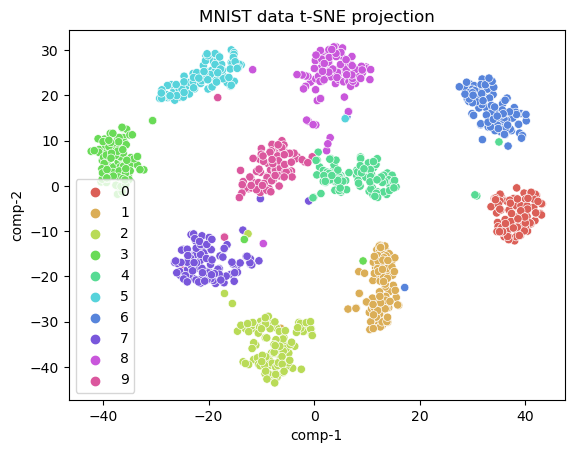

In [62]:
images, labels = next(iter(trainloader))
f = trained_model.feature(images)

tsne = TSNE(n_components=2,random_state=123)
z = tsne.fit_transform(f.detach().numpy())
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data t-SNE projection")

[Text(0.5, 1.0, 'MNIST data PCA projection')]

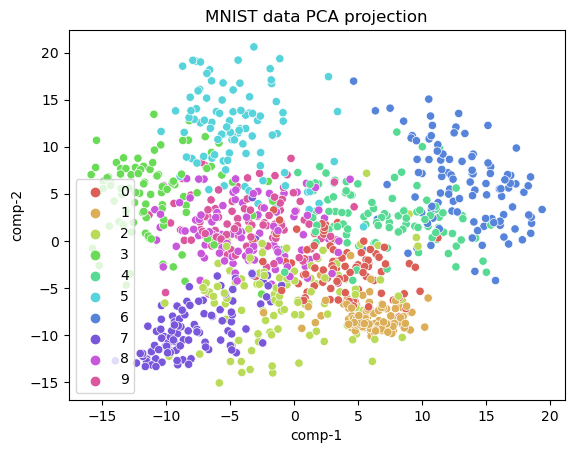

In [63]:
pca = PCA(n_components=2)
p = pca.fit_transform(f.detach().numpy())

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = p[:,0]
df["comp-2"] = p[:,1]

sns.scatterplot(x="comp-1",y="comp-2",hue=df.y.tolist(), 
                palette= sns.color_palette("hls",10), 
                data=df).set(title="MNIST data PCA projection")

## Task 6

a) As can be seen from the scatterplot images of t-SNE and the PCA, the t-SNE performse better then the PCA in the sense that it preserves global structures, if we could see the actual images in the scatterplot we would also see that the t-SNE also preserves local structures as well. It also have an easier time seperating the diffrent classes then the PCA does.

b) Even though the well trained model performed better then the non-trained model, it was still an acceptable outcome, at least in the case of the t-SNE projection. As for the PCA, it absolutly needed to be trained to be of any use. The non-trained PCA is close to useless when it came to class separation, with the sole exeption of the 1's.       